# Introduction

In this notebook, we'll simply load the data, downcast it using a technique I learned from [this](https://www.kaggle.com/code/vaibhavgupta082/time-series-forecasting-eda-fe-modelling-679c92) notebook and do some pre-processsing work before analysis

In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings('ignore')

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

In [3]:
# GLOBAL VARIABLES
DATA_PATH = "../../m5-data/"

WALMART_COLOURS = ["#0072CE", "#B4B4B3", "#79B8F3", "#FDB927", "#F7941D", "#4CB748", "#2E3192"]
DIVERGENT_COLOUR_GRADIENT = ["#e2f1fc", "#b9dcfa", "#8cc7f7", "#5eb1f3", "#39a0f1", "#0691ef"]
sns.set_palette(WALMART_COLOURS)


In [4]:
# data paths
sales_path = os.path.join(DATA_PATH, "sales_train_evaluation.csv")
calendar_path = os.path.join(DATA_PATH, "calendar.csv")
prices_path = os.path.join(DATA_PATH, "sell_prices.csv")
mlt_sales_path = os.path.join(DATA_PATH, "melted_sales.csv")

In [5]:
sales = pd.read_csv(sales_path)
calendar = pd.read_csv(calendar_path)
prices = pd.read_csv(prices_path)
mlt_sales = pd.read_csv(mlt_sales_path)

In [ ]:
#Add zero sales for the remaining days 1942-1969
for d in range(1942,1970):
    col = 'd_' + str(d)
    sales[col] = 0
    sales[col] = sales[col].astype(np.int16)

# Functions

In [6]:
def get_df_memory(df):
  return np.round(df.memory_usage().sum()/(1024*1024),1)

def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df 

In [7]:
def plot_time_series(data, title):
  fig, ax = plt.subplots(figsize=(15, 6), layout="constrained")
  _ = sns.lineplot(data=data, ax=ax)
  _ = fig.suptitle(title, fontsize=16)

In [8]:
def add_stl_plot(fig, res, legend):
    """Add 3 plots from a second STL fit"""
    axs = fig.get_axes()
    comps = ["trend", "seasonal", "resid"]
    for ax, comp in zip(axs[1:], comps):
        series = getattr(res, comp)
        if comp == "resid":
            ax.plot(series, marker="o", linestyle="none")
        else:
            ax.plot(series)
            if comp == "trend":
                ax.legend(legend, frameon=False)


In [9]:
def view_decomposition(df):
  res_robust = STL(df, period=52, robust=True).fit()
  fig = res_robust.plot()
  res_non_robust = STL(df, period=52, robust=False).fit()
  add_stl_plot(fig, res_non_robust, ["Robust", "Non-robust"])

In [10]:
sales_bd = get_df_memory(sales)
calendar_bd = get_df_memory(calendar)
prices_bd = get_df_memory(prices)
mlt_sales_bd = get_df_memory(mlt_sales)

In [11]:
sales = downcast(sales)
prices = downcast(prices)
calendar = downcast(calendar)
mlt_sales = downcast(mlt_sales)

In [9]:
sales_ad = get_df_memory(sales)
calendar_ad = get_df_memory(calendar)
prices_ad = get_df_memory(prices)
mlt_sales_ad = get_df_memory(mlt_sales)

In [10]:
memory = {
  'DataFrame':['sales','calendar','prices'],
  'Before downcasting':[sales_bd,calendar_bd,prices_bd],
  'After downcasting':[sales_ad,calendar_ad,prices_ad]
}

memory = pd.DataFrame(memory)
memory = pd.melt(memory, id_vars='DataFrame', var_name='Status', value_name='Memory (MB)')
memory.sort_values('Memory (MB)',inplace=True)
fig = px.bar(memory, x='DataFrame', y='Memory (MB)', color='Status', color_discrete_sequence=WALMART_COLOURS, barmode='group', text='Memory (MB)')
fig.update_traces(texttemplate='%{text} MB', textposition='outside')
fig.update_layout(template='seaborn', title='Effect of Downcasting')
fig.show()

# Understanding The Data

Now that we've downcasted the data, we can now trying and wrap our heads around what's in the data. The M5 dataset, generously made available by Walmart, involves the unit sales of various products sold in the USA, organized in the form of **grouped time series**. We have 3 049 products classified into 3 product categories (Hobbies, Foods and Household). We then have 7 product department in under which these categories are aggregated.
These products are sold in 10 stores across 3 states: California(CA), Texas(TA) and Wisconsin(WI).

We can visualize this distribution as follows:

In [11]:
sales_group = sales.groupby(['state_id','store_id','cat_id','dept_id'],as_index=False)['item_id'].count().dropna()
sales_group.head()

,state_id,store_id,cat_id,dept_id,item_id
0,CA,CA_1,FOODS,FOODS_1,216
1,CA,CA_1,FOODS,FOODS_2,398
2,CA,CA_1,FOODS,FOODS_3,823
3,CA,CA_1,FOODS,HOBBIES_1,0
4,CA,CA_1,FOODS,HOBBIES_2,0


In [12]:
group = sales.groupby(['state_id','store_id','cat_id','dept_id'],as_index=False)['item_id'].count().dropna()
group = group[group['item_id'] > 0].reset_index(drop=True) # removing zero-valued rows
group['USA'] = 'United States of America'
group.rename(columns={'state_id':'State','store_id':'Store','cat_id':'Category','dept_id':'Department','item_id':'Count'},inplace=True)
fig = px.treemap(
  group, 
  path=['USA', 'State', 'Store', 'Category', 'Department'], 
  values='Count',
  color='Count',
  color_continuous_scale= DIVERGENT_COLOUR_GRADIENT,
  title="Walmart's Item Distribution"
)
fig.update_layout(template='seaborn')
fig.show()

We learn from the above graph that items are distributed in a similar manner across states, stores and product departments; all 3 states under analysis have the same number of products across stores and product categories. A curious question might be: do they really sell the same products? For now, I don't think it's worthwhile to answer this question.

The above graph also suggests the logic in which we can explore the data. +3000 products is a really a lot and thus needs systematic approach to analysis.

In [8]:
mlt_sales = pd.melt(sales, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='sold').dropna()

In [14]:
mlt_sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


In [9]:
mlt_sales = pd.merge(mlt_sales, calendar[['date', 'd']], on='d', how='left')
mlt_sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,date
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29


In [10]:
mlt_sales['date'] = pd.to_datetime(mlt_sales['date'])
mlt_sales = mlt_sales.set_index('date')

In [17]:
daily_total_sales = mlt_sales.groupby('date')['sold'].sum()
daily_total_sales.head()

date
2011-01-29    32631
2011-01-30    31749
2011-01-31    23783
2011-02-01    25412
2011-02-02    19146
Name: sold, dtype: int64

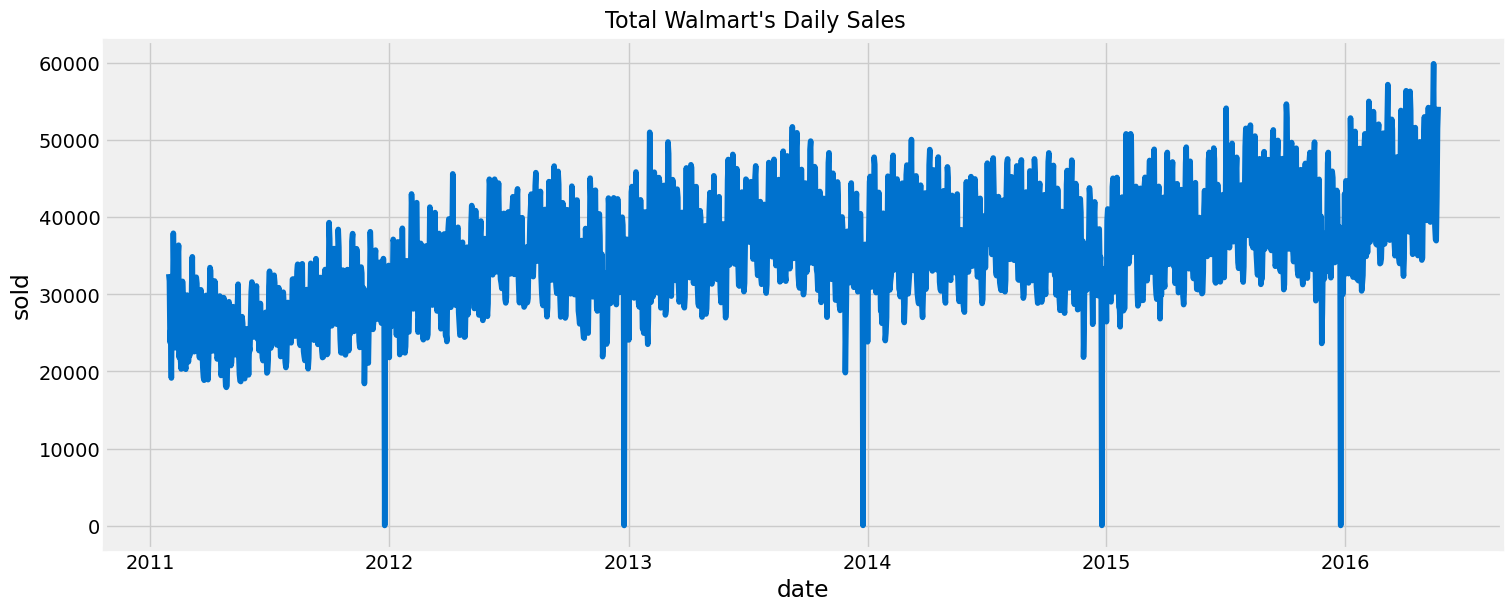

In [19]:
plot_time_series(daily_total_sales, "Total Walmart's Daily Sales")

The time series under consideration show a slightly increasing trend with yearly seasonality; with the exception of 2011, we seem to have a concave shape in a year where total sales start at a certain point, grow until somewhere after mid-year where a decline is seen. This decline consistently ends with a very sharp drop every year. I've checked and learned that it's the 25 of December every year(as expected) where the sales drop to about 20 per day. Which is a very weird thing to happen; from an average of 30 000 sales per day to 20 is just weird. My initial thought would be that this is probably a simulated dataset, but then again, I don't live in the US, so I don't know how things go over there.

Back to 2011; it's different because in the period of the year when the total sales peak, this was when they were rock-bottom in 2011. This is probably irrelavant for future forecasting.

So far, then I suppose we should check the kinds of holidays marked in the `calendar` dataset, because I still maintain we should have a feature specific to checking whether the date is the 25th of December or not.

In [ ]:
daily_total_sales[daily_total_sales.values < 100]

In [20]:
calendar['date'] = pd.to_datetime(calendar['date'])
calendar.set_index('date', inplace=True)
calendar['is_christmas'] = ((calendar.index.month == 12) & (calendar.index.day == 25)).astype(int)
calendar.head()

,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,is_christmas
date,,,,,,,,,,,,,,
2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,0
2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,0
2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,0
2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0,0
2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1,0


### Creating the Melted Sales .csv

Create this dataset so I won't have to recompute it everytime I load this notebook

In [11]:
mlt_sales['is_christmas'] = ((mlt_sales.index.month == 12) & (mlt_sales.index.day == 25)).astype(int)

In [12]:
mlt_sales.head(10)

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,is_christmas
date,,,,,,,,,
2011-01-29,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,0
2011-01-29,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,0
2011-01-29,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,0
2011-01-29,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,0
2011-01-29,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,0
2011-01-29,HOBBIES_1_006_CA_1_evaluation,HOBBIES_1_006,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,0
2011-01-29,HOBBIES_1_007_CA_1_evaluation,HOBBIES_1_007,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,0
2011-01-29,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_1,12,0
2011-01-29,HOBBIES_1_009_CA_1_evaluation,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,d_1,2,0


In [13]:
mlt_sales.to_csv('../../m5-data/melted_sales.csv', index=False)

# Trend, Seasonality and Residuals

At this point, we'd like to get a clear sense of the trend, seasonality and residuals. Looking at the graph above, we'll try some resampling then use seasonal decompose function to see these components.

In [14]:
weekly_sales = mlt_sales[['sold']].resample('W').sum()

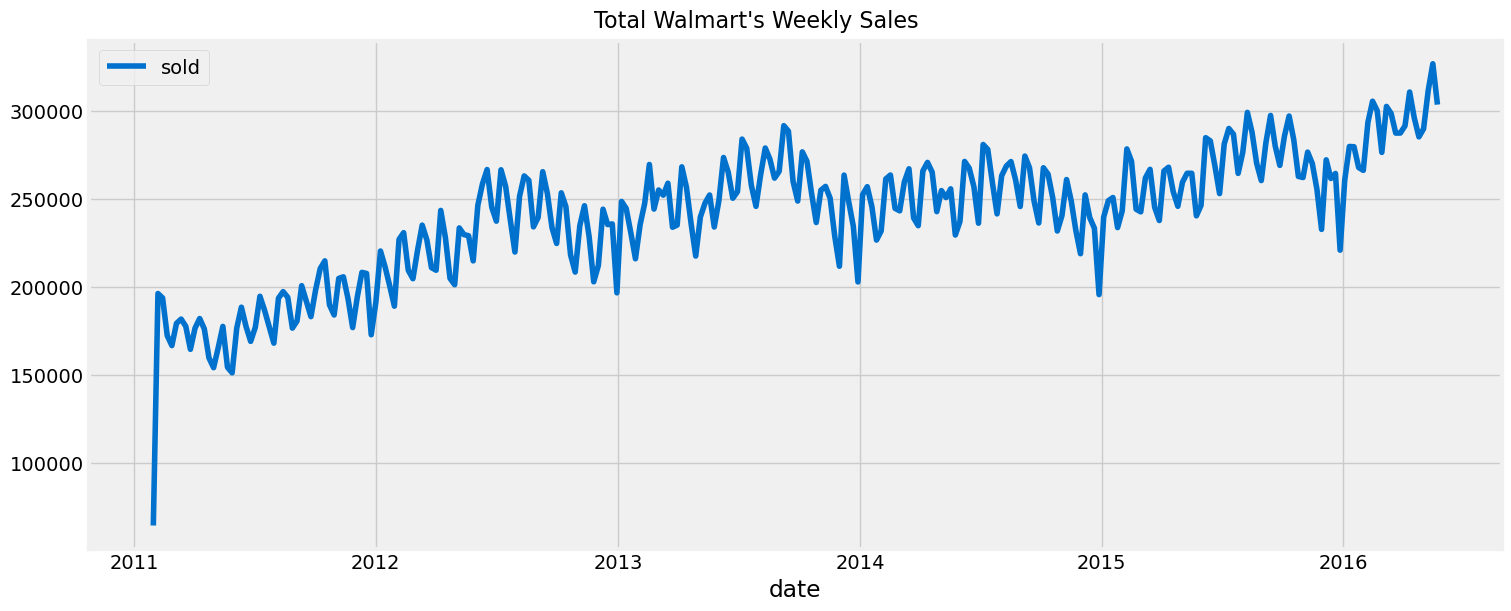

In [17]:
plot_time_series(weekly_sales, "Total Walmart's Weekly Sales")

## What can we make of these?

In general, it seems there's SOME seasonality in the data where the sales drop in the beginning and at the end of the year, then peak somewhere around June and August. This is seen from 2012 because 2011 seems to have an opposite trend with a convex shape and not the concave shape seen in other years. \
In addition, 2012, 2013, 2015 and 2016 seem have had more increased sales during the peak months. I might have to investigate this as I assume this will be reflected by some exogenous variables which I have to deduce.

To estimate the trend and seasonality of the above, let's start with the `Seasonal-Trend Decomposition using LOESS`.

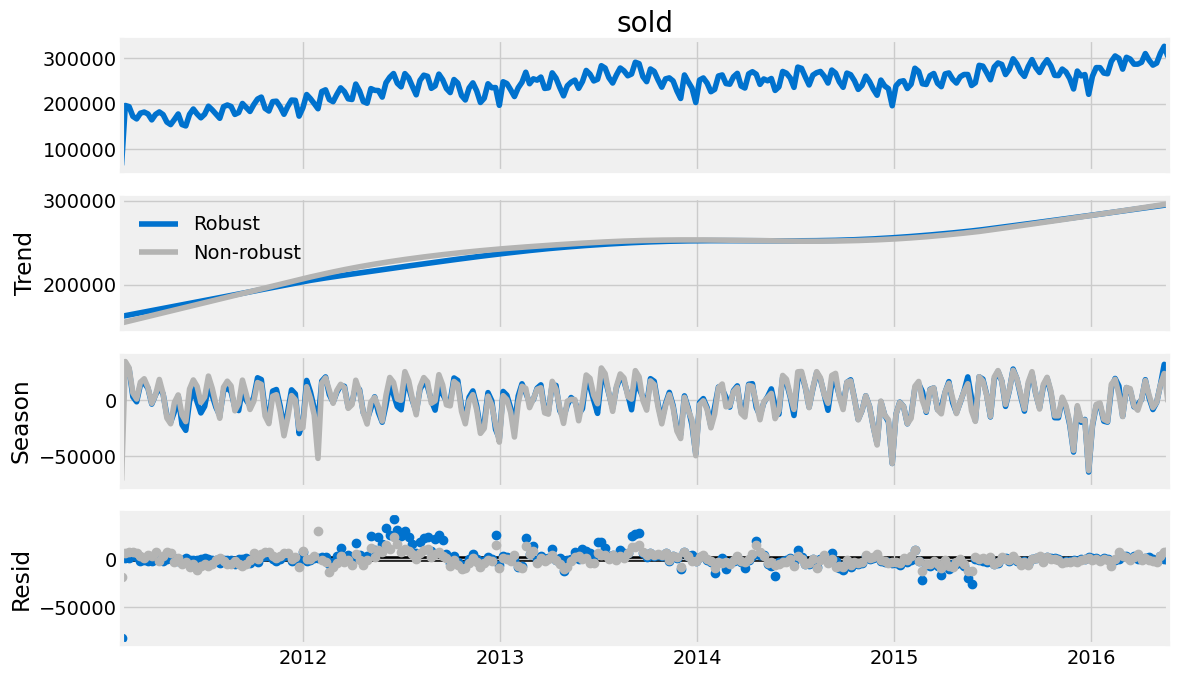

In [20]:
view_decomposition(weekly_sales['sold'])

### The fun of working with real-data...

The data is not what you normally get reading textbooks. Oh, what fun. Right now I'm having trouble describing the seasonal component and I think this is because:
- We're using aggregated values of thousands of products
- Also, there might also be more going on e.g. inteventions employed as a consequence varying factors in the business, especially during mid-year of 2012. Those pronounced residuals around the months of June are more likely to be explainable by some exogenous variables as I said earlier. It would be interesting to ask around if we were at Walmart.

Anyway, we can't fold our hands and do nothing. For example, we can identify and model the trend because it's sort of representative of a cubic function of the form: $y = ax^3$ where $a$ is really small, somewhere along 0.003 or so. As always, one ought to be careful that this might just end at any time or a completely new trend might emerge. However, with the data we have, this seems to work, we'll get back to it. \
Additionally, seasonality still looks to me as repeated dome-shapes. However, it seems more visible after 2013; when the trend was on an upward trajectory from 2011-2012, the seasonality wasn't apparent, but as soon as the trend flat-lined, then the seasonality was more visible.

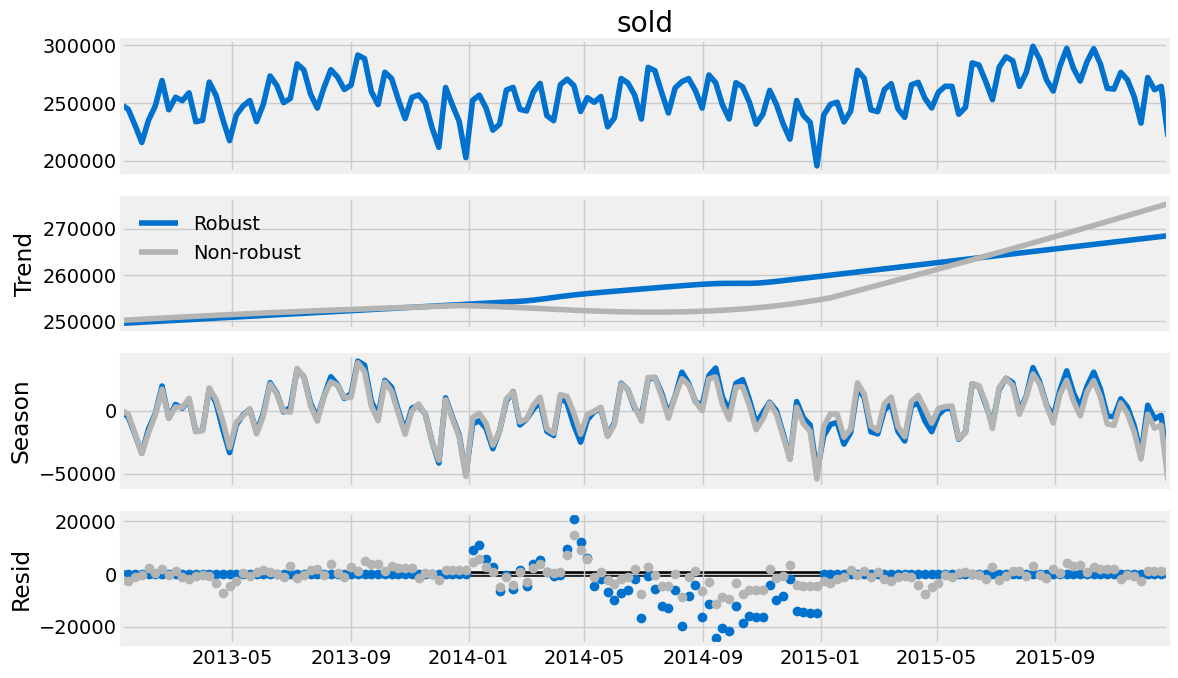

In [21]:
view_decomposition(weekly_sales['sold']['2013-01-01': '2015-12-31'])

Let's find out what happened in 2012 and 2014 during the peak months.

In [22]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [23]:
prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.578125
1,CA_1,HOBBIES_1_001,11326,9.578125
2,CA_1,HOBBIES_1_001,11327,8.257812
3,CA_1,HOBBIES_1_001,11328,8.257812
4,CA_1,HOBBIES_1_001,11329,8.257812


In [26]:
calendar_date = calendar.reset_index(inplace=False)[['date', 'wm_yr_wk']]
calendar_date.head()

,date,wm_yr_wk
0,2011-01-29,11101
1,2011-01-30,11101
2,2011-01-31,11101
3,2011-02-01,11101
4,2011-02-02,11101


In [27]:
prices = pd.merge(prices, calendar_date, on='wm_yr_wk', how='left').set_index('date')
prices.head()

,store_id,item_id,wm_yr_wk,sell_price
date,,,,
2013-07-13,CA_1,HOBBIES_1_001,11325,9.578125
2013-07-14,CA_1,HOBBIES_1_001,11325,9.578125
2013-07-15,CA_1,HOBBIES_1_001,11325,9.578125
2013-07-16,CA_1,HOBBIES_1_001,11325,9.578125
2013-07-17,CA_1,HOBBIES_1_001,11325,9.578125


In [31]:
weekly_sum_prices = prices['sell_price'].resample('M').sum()

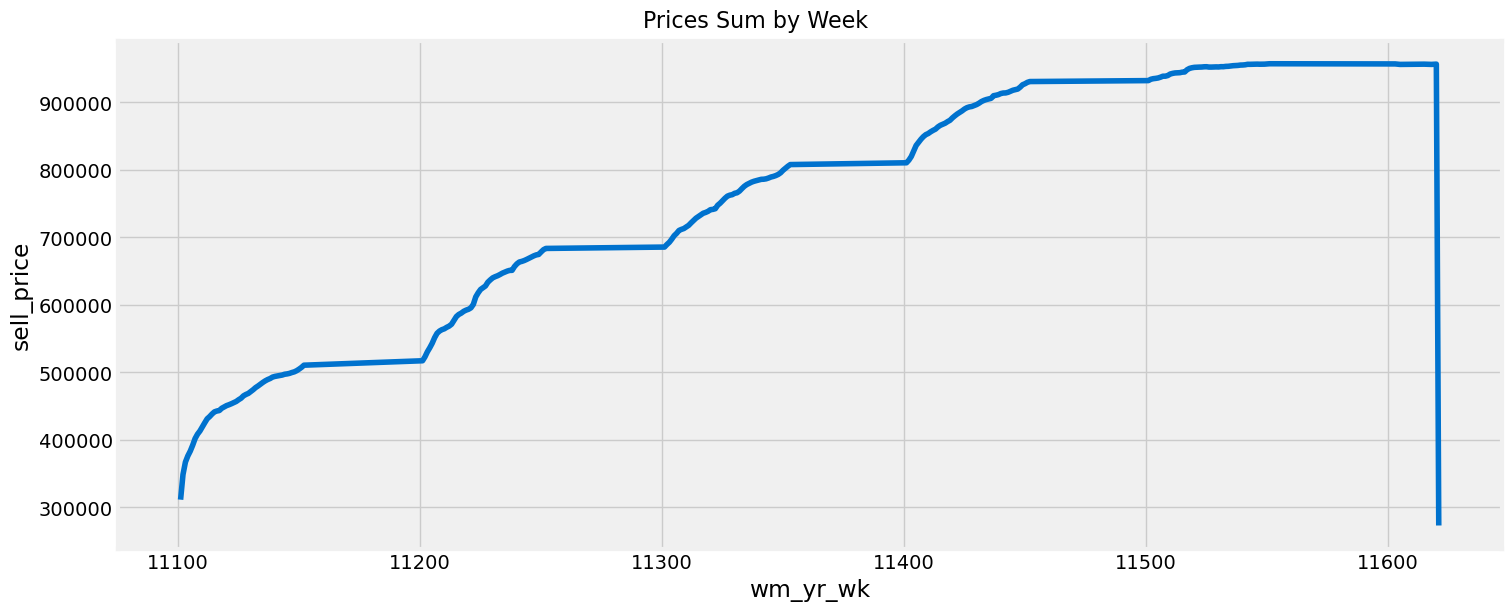

In [29]:
plot_time_series(weekly_sum_prices, "Prices Sum by Week")

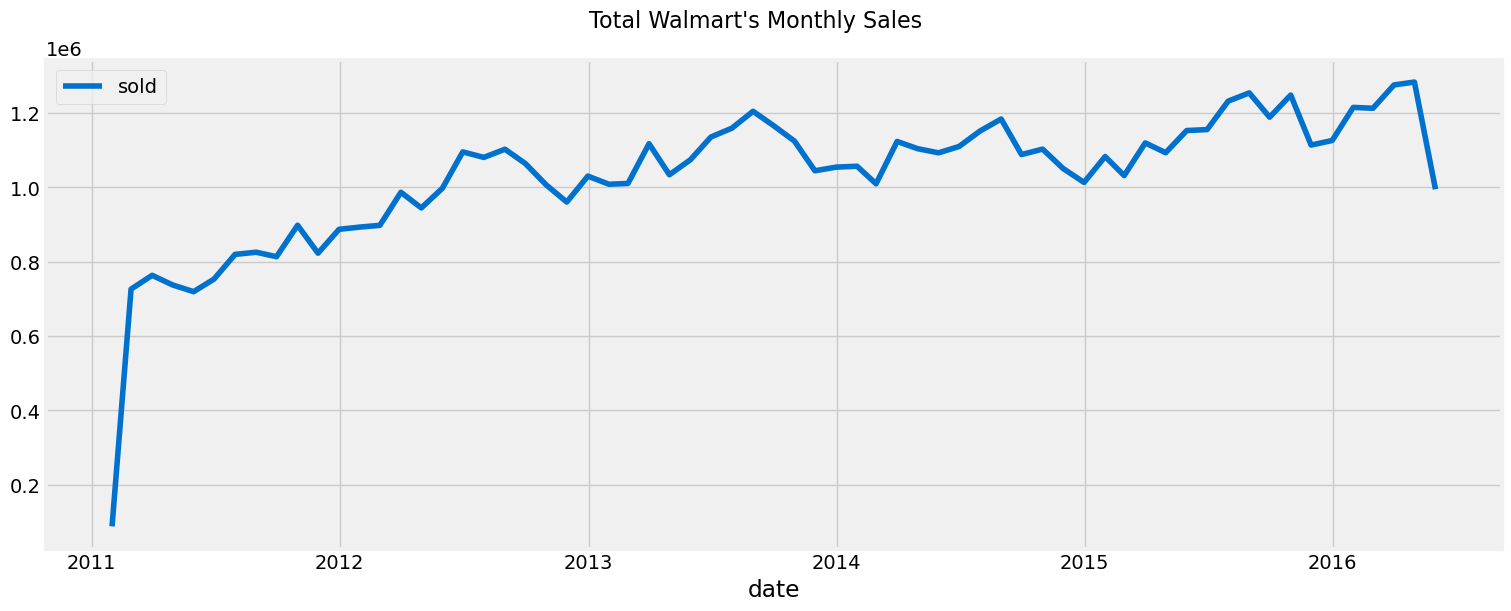

In [24]:
monthly_sales = mlt_sales[['sold']].resample('M').sum()
plot_time_series(monthly_sales, "Total Walmart's Monthly Sales")

The Weekly resample is indeed a little smoother that the original data, but however, doesn't clearly show the trend, hence a further resampling which downsampled by months. Looking at the monthly sales per year, it seems we can get a clear picture of the seasonality by graphing the average sales per month. Anyway, from here onwards, let's see what the `seasonal_decompose` function gives us. We'll be using the weekly sales data because, even though the monthly sales time-series is much smoother, way too much information is lost.

# Are We On a Random Walk?

Now that we've concluded to working with a relatively smoother time series(weekly sales), we can start our iterative modelling journey to get a better sense of the data; starting with the simplest statistical models and building our way up.

To that end, we'll start with assuming a random walk and seeing where this takes us. This - to me - doesn't sound like a completely invalid assumption especially if we think of it as a random walk without a drift, meaning it will be in the form:
$$
\begin{aligned}
  x_{t} &= \delta t + \sum_{j = 1}^{N}w_{j} \\
  \implies x_{t} &= \sum_{j = 1}^{N}w_{j}, \text{ since } \delta = 0
\end{aligned}
$$
where $w_{t} \sim wn(0, \sigma_{w}^2)$.

This being said, we'll first check if our assumed random walk is stationary, in which case we'll also check autocorrelation to confirm this as a random walk. If not stationary, then we'll try a few transformations until stationarity is reasonably reached. If not reached, then we'll move on to other models whose parameters aren't static.

In [ ]:
def check_stationarity(df):
  adf_results = adfuller(df)
  print(f"ADF statistic = {adf_results[0]}\np-value = {adf_results[1]}")

In [ ]:
check_stationarity(weekly_sales['sold'])

In [ ]:
# Due to non-stationarity, let's try first-order differencing

weekly_sales['1-diff'] = weekly_sales['sold'].diff(periods=1)
weekly_sales.head()

In [ ]:
plot_time_series(weekly_sales['1-diff'], "Sales: After first-order Differencing")

In [ ]:
check_stationarity(weekly_sales['1-diff'].dropna(inplace=False))

The p-value is well below 0.05 and the ADF statistic is reasonably large(on the negative side), meaning we can now reject the test's null hypothesis that there's a unit root(implying stationarity) after first-order differencing. Our next step is to now check for auto-correlation using the `ACF`.

In [ ]:
_ = plot_acf(weekly_sales['1-diff'].dropna(inplace=False), lags=52)

The plotted autocorrelation function above suggests there's still some temporal dependence between observations as autocorrelation is clearly observed. A noteworthy point is that the way it looks however, does give us more confidence that we atleast have no linear trend. But this doesn't make us forget about the decision that we have to make i.e. our we deseasonalizing the time series or we consider a seasonal model?

I think it's better to consider a seasonal model, otherwise we might just end up with more and more transformation just trying to get the data to behave like a random walk even if it's inherently not a random walk process.

That being said, we've come to the end of our analysis for this notebook. We'll continue on the next notebook considering other statistical models until we've tried machine learning and deep learning techniques.